# Preparing the pickle files for `State-evolution` cluster runs of particles transitioning through the quadrupole lens

Particles propagate from a homogenous field in z to the quadrupole field in the yz plane back into a homogeneous field in z.  
The homogeneous field can be offset with a scaling factor, where `scaling factor = 1` corresponds to an offset of -1000kV of both electrodes.
The `scaling factor` and `trajectory idx` are iterated over on the cluster

In [1]:
from utils.fields import *
from utils.trajectories import *
from utils.setfontsize import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
pickle_dir = 'options pickles/'
trajectory_dir = 'trajectories/'

In [3]:
from trajectories import *
positions = load_trajectories(trajectory_dir+'positions_545.mat')
velocities = load_velocities(trajectory_dir+'velocities_545.mat')

t, (xT, yT, zT), (xVelocity, yVelocity, zVelocity) = get_time_position_velocity(positions, velocities)

In [4]:
def makeInterpolate(t,x,y,z):
    """
    Note that for the field simulations the molecular
    beam directin is z.
    Interpolating the trajectories, quadruatic for 
    gravitational shift, linear otherwise.
    """
    intTrajX = interp1d(t, x, kind = 'linear')
    intTrajY = interp1d(t, y, kind = 'quadratic')
    intTrajZ = interp1d(t, z, kind = 'linear')

    rootfun = lambda t: intTrajZ(t) - (0.8052-0.15)
    tstart = brentq(rootfun, 0.001, 0.015)
    rootfun = lambda t: intTrajZ(t) - (0.8052+0.6+0.15)
    tstop = brentq(rootfun, 0.001, 0.015)
    
    intTrajX = interp1d(t-tstart, x, kind = 'linear')
    intTrajY = interp1d(t-tstart, y, kind = 'quadratic')
    intTrajZ = interp1d(t-tstart, z-(0.8052-0.15)-0.45, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tstop-tstart

In [5]:
interpolateTrajectories = []
for idInt in range(t.shape[1]):
    interpolateTrajectories.append((makeInterpolate(t[:,idInt], xT[:,idInt], yT[:,idInt], zT[:,idInt])))

In [6]:
del t, xT, yT, zT, xVelocity, yVelocity, zVelocity

generating the interpolating functions for the homogeneous potential and quadrupole potential  
`quadrupole field` : `c` is a matrix containing the 3rd order polynomial terms in x and y; `intfun` is a spline function for the field along the z axis  
`homogeneous field` : `cP` is a matrix containing the 3rd order polynomial terms in x and y; `intfunP` is a spline function for the field along the z axis

In [48]:
c, intfun = fit_potential_xyz("D:/Adiabatic Transfer/propagation/fields/"+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz('D:/Adiabatic Transfer/propagation/fields/'+'potentialElectrodes.fld', 0.022, 0.019, .45, 0)
cP_offset, intfunP_offset = fit_potential_xyz('D:/Adiabatic Transfer/propagation/fields/'+'potentialElectrodes_offset_-1kV_no_differential.fld', 0, 0.0, .45, 0)

taking the derivatives of the polynomial fits to facilitate the field calculations in `State-evolution`

In [49]:
from numpy.polynomial import polynomial

x_cder = polynomial.polyder(c, axis = 0)
x_cPder = polynomial.polyder(cP, axis = 0)
x_cPOder = polynomial.polyder(cP_offset, axis = 0)
y_cder = polynomial.polyder(c, axis = 1)
y_cPder = polynomial.polyder(cP, axis = 1)
y_cPOder = polynomial.polyder(cP_offset, axis = 1)

pickling the spline functions and 2d polynomial matrices for use in `State-evolution`

In [50]:
import pickle 

with open(pickle_dir+'potential_plate_z_run2.pkl', 'wb') as wfp:
    pickle.dump(intfunP, wfp)
    
with open(pickle_dir+'potential_plate_offset_z_run2.pkl', 'wb') as wfp:
    pickle.dump(intfunP_offset, wfp)
    
with open(pickle_dir+'potential_quadrupole_z_run2.pkl', 'wb') as wfp:
    pickle.dump(intfun, wfp)
    
with open(pickle_dir+'potential_plate_xy_run2.pkl', 'wb') as wfp:
    pickle.dump([cP, x_cPder, y_cPder], wfp)
    
with open(pickle_dir+'potential_plate_offset_xy_run2.pkl', 'wb') as wfp:
    pickle.dump([cP_offset, x_cPOder, y_cPOder], wfp)
    
with open(pickle_dir+'potential_quadrupole_xy_run2.pkl', 'wb') as wfp:
    pickle.dump([c, x_cder, y_cder], wfp)
    
with open(pickle_dir+'trajectories_run2.pkl', 'wb') as wfp:
    pickle.dump(interpolateTrajectories, wfp)

### Checking if the fields make physical sense

In [51]:
Ex = lambda x,y,z: intfunP_offset(z)*polynomial.polyval2d(x,y,x_cPOder)/100
Ey = lambda x,y,z: intfunP_offset(z)*polynomial.polyval2d(x,y,y_cPOder)/100
Ez = lambda x,y,z: intfunP_offset.derivative()(z)*polynomial.polyval2d(x,y,cP_offset)/100

coords = lambda t: (0*t, 0*t, -0.45+t)

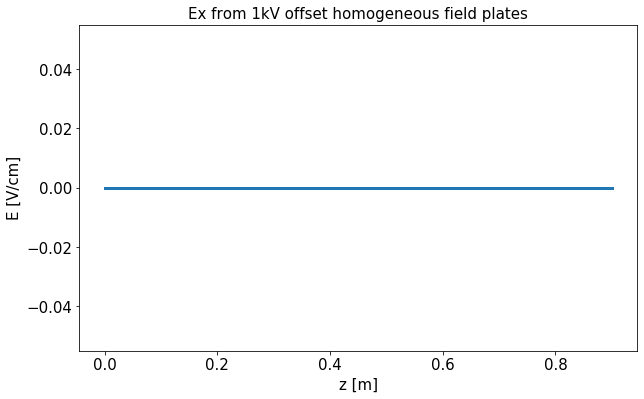

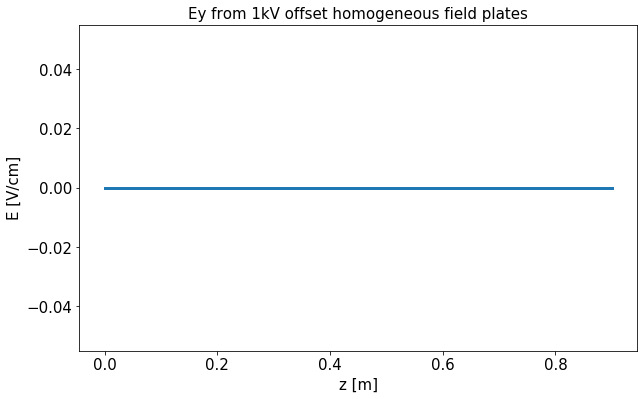

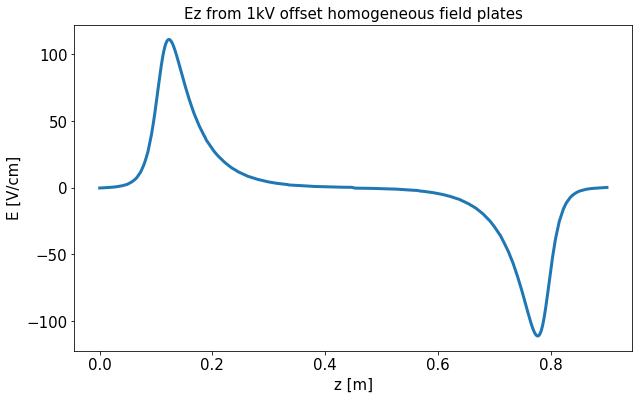

In [52]:
t = np.linspace(0, 0.9, 1000)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ex(*coords(t)), lw = 3)
ax.set_title('Ex from 1kV offset homogeneous field plates')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ey(*coords(t)), lw = 3)
ax.set_title('Ey from 1kV offset homogeneous field plates')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ez(*coords(t)), lw = 3)
ax.set_title('Ez from 1kV offset homogeneous field plates')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

Fields look as expected, no field in x and y, with the only field being the small transitions from the homogeneous field to the outer field.

In [53]:
Ex = lambda x,y,z,offset,amp: offset*intfunP_offset(z)*polynomial.polyval2d(x,y,x_cPOder)/100 + \
                              amp*intfunP(z)*polynomial.polyval2d(x,y,x_cPder)/100
Ey = lambda x,y,z,offset,amp: offset*intfunP_offset(z)*polynomial.polyval2d(x,y,y_cPOder)/100 + \
                              amp*intfunP(z)*polynomial.polyval2d(x,y,y_cPder)/100
Ez = lambda x,y,z,offset,amp: offset*intfunP_offset.derivative()(z)*polynomial.polyval2d(x,y,cP_offset)/100 + \
                              amp*intfunP.derivative()(z)*polynomial.polyval2d(x,y,cP)/100

coords = lambda t: (0*t, 0*t, -0.45+t)

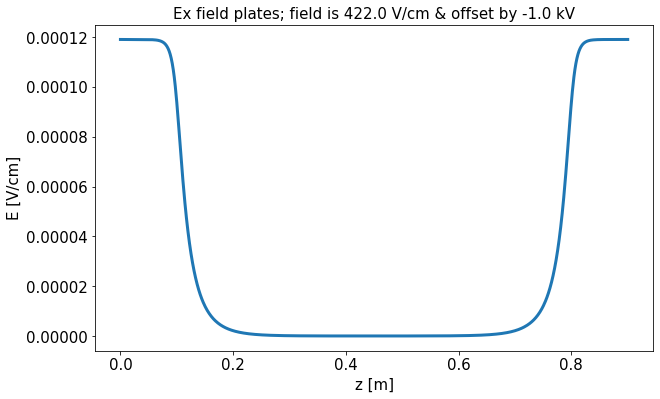

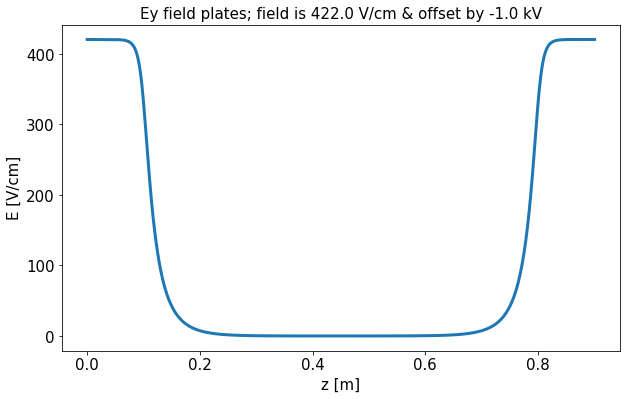

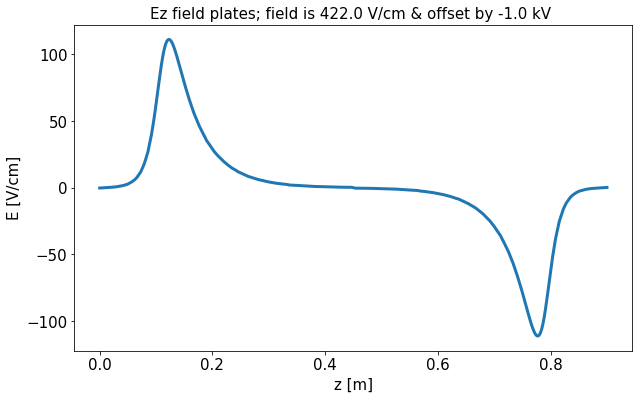

In [59]:
t = np.linspace(0, 0.9, 1000)
offset = 1
amp = 5

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ex(*coords(t), offset, amp), lw = 3)
ax.set_title(f'Ex field plates; field is {amp*84.4:.1f} V/cm & offset by {offset*-1:.1f} kV')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ey(*coords(t), offset, amp), lw = 3)
ax.set_title(f'Ey field plates; field is {amp*84.4:.1f} V/cm & offset by {offset*-1:.1f} kV')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(t, Ez(*coords(t), offset, amp), lw = 3)
ax.set_title(f'Ez field plates; field is {amp*84.4:.1f} V/cm & offset by {offset*-1:.1f} kV ')
ax.set_ylabel('E [V/cm]')
ax.set_xlabel('z [m]')
set_fontsize(ax, 15)